## Installing Libraries

In [1]:
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install ultralytics

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install -U ipywidgets

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install --user albumentations

Note: you may need to restart the kernel to use updated packages.


In [1]:
pip install opencv-python



SyntaxError: invalid syntax (556306433.py, line 1)

## Importing Libraries

In [3]:
import torch
import torch.cuda

import os
from PIL import Image, ImageDraw, ImageFont
import cv2
import random
import shutil
import numpy as np
from pathlib import Path
import albumentations as A
from ultralytics import YOLO
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import re
from collections import Counter

C:\Users\aswan\AppData\Roaming\Python\Python39\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## Testing cuda availability (GPU)

In [3]:
torch.cuda.is_available()

True

In [4]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 4060 Laptop GPU'

In [5]:
torch.cuda.device_count()

1

## About Dataset

CAUCAFall is a database created with the aim of recognizing human falls, where its differential feature lies in the fact that it is  created in conditions of an uncontrolled home environment, with occlusions, changes in lighting (natural, artificial, and night), variety in the clothing of the participants, movement in the background, different textures on the floor and room, variety in the angles of fall, different distances from the camera to the fall, with participants of different age, weight, height, and even different dominant leg, which contributes to the real progress of research in the recognition of falls. In addition, the proposed database is the only one that contains segmentation labels in each of its images, which serve to be able to implement human fall recognition methods by means of YOLO detectors.

Subjects simulated 5 types of falls and 5 types of activities of daily living (ADLs). The data included forward falls, backward falls, falls to the left, falls to the right, and falls arising from sitting. The ADLs performed by the participants are: walking, hopping, picking up an object, sitting, and finally kneeling. Frames that recorded human falls were labeled as "fall" and ADLs were labeled as "no-fall".

The data are organized into 10 main directories corresponding to the subjects, each of which contains 10 folders with the different activities performed by the participants, and in each folder there is a video of the action in .avi format, the images of the actions in .png format, and each of the frame segmentation labels in .txt format.

### Dataset directory structure

In [7]:
#"""
#    C:\..\..\College Project\Dataset CAUCAFall\
#    ├── subject.1\
#    │   ├── forward falls\
#    │   │   ├── image1.png
#    │   │   ├── image1.txt
#    │   │   ├── action.avi
#    │   ├── backward falls\
#    │   ├── ...
#    ├── subject.2\
#    ├── ...
#"""

## Visualizing images with bounding box

In [4]:
def draw_bbox(image_path, annotation_path):
    # Load image
    image = cv2.imread(image_path)
    h, w = image.shape[:2]
    
    # Read annotation
    with open(annotation_path, 'r') as file:
        lines = file.readlines()

    for line in lines:
        parts = line.strip().split()
        class_id = int(parts[0])
        x_center, y_center, width, height = map(float, parts[1:])

        # Convert YOLO format (normalized) to pixel coordinates
        x1 = int((x_center - width / 2) * w)
        y1 = int((y_center - height / 2) * h)
        x2 = int((x_center + width / 2) * w)
        y2 = int((y_center + height / 2) * h)

        # Define color and label
        if class_id == 1:  # fall
            color = (0, 0, 255)  # Red
            label = "FALL"
        else:  # non-fall
            color = (0, 255, 0)  # Green
            label = "NON-FALL"

        # Draw bounding box
        cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
        cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

    # Convert BGR image to RGB (for matplotlib display)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display image in Jupyter notebook
    plt.imshow(image_rgb)
    plt.axis('off')  # Hide axis
    plt.show()



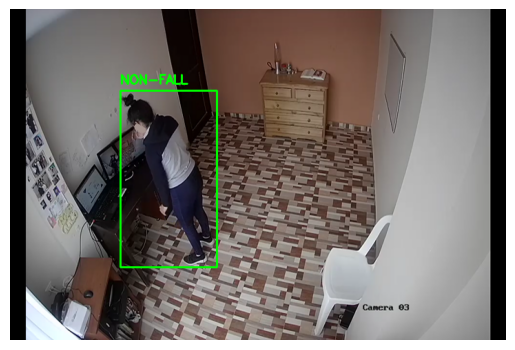

In [16]:
# non fall image
image_path = r"C:\Users\aswan\College Project\CaucaFall dataset\images\train\cas100002.png"
annotation_path = r"C:\Users\aswan\College Project\CaucaFall dataset\labels\train\cas100002.txt"

draw_bbox(image_path, annotation_path)


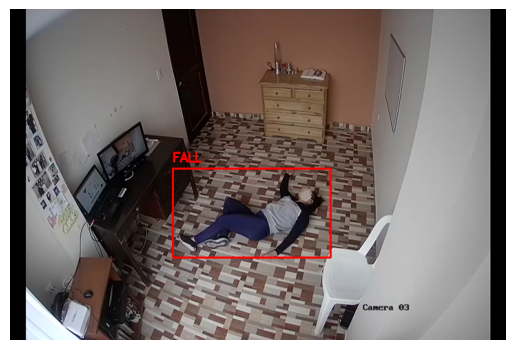

In [18]:
# fall image
image_path = r"C:\Users\aswan\College Project\CaucaFall dataset\images\train\cas100096.png"
annotation_path = r"C:\Users\aswan\College Project\CaucaFall dataset\labels\train\cas100096.txt"

draw_bbox(image_path, annotation_path)

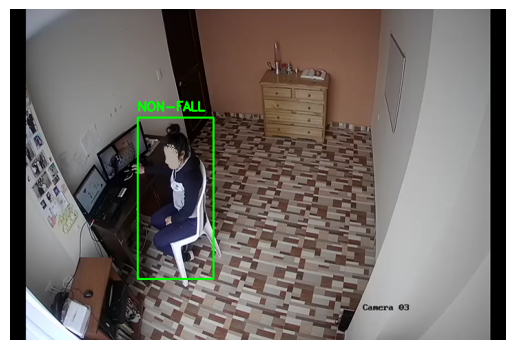

In [19]:
# non fall image (kneeling position)
image_path = r"C:\Users\aswan\College Project\CaucaFall dataset\images\train\ses100139.png"
annotation_path = r"C:\Users\aswan\College Project\CaucaFall dataset\labels\train\ses100139.txt"

draw_bbox(image_path, annotation_path)


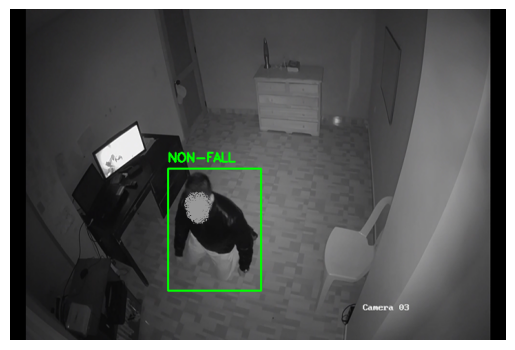

In [20]:
# non fall image (sitting position)
image_path = r"C:\Users\aswan\College Project\CaucaFall dataset\images\train\ars600167.png"
annotation_path = r"C:\Users\aswan\College Project\CaucaFall dataset\labels\train\ars600167.txt"

draw_bbox(image_path, annotation_path)



## Moving all the data into fall and non fall category

In [16]:
# Define the base path
base_dir = Path(r"C:\Users\aswan\College Project")
main_folder = base_dir / "all_images_and_labels"

# Define all subdirectories to create
folders_to_create = [
    main_folder / "images" / "fall",
    main_folder / "images" / "non fall",
    main_folder / "labels" / "fall",
    main_folder / "labels" / "non fall",
]

# Create directories
for folder in folders_to_create:
    folder.mkdir(parents=True, exist_ok=True)
    print(f"Created: {folder}")

Created: C:\Users\aswan\College Project\all_images_and_labels\images\fall
Created: C:\Users\aswan\College Project\all_images_and_labels\images\non fall
Created: C:\Users\aswan\College Project\all_images_and_labels\labels\fall
Created: C:\Users\aswan\College Project\all_images_and_labels\labels\non fall


In [17]:
def organize_images_by_label(subject_path):
    subject_path = Path(subject_path)

    # Output directories
    base_output = Path(r"C:\Users\aswan\College Project\all_images_and_labels")
    image_fall_dir = base_output / "images" / "fall"
    image_nonfall_dir = base_output / "images" / "non fall"
    label_fall_dir = base_output / "labels" / "fall"
    label_nonfall_dir = base_output / "labels" / "non fall"

    # Get activity folders inside the subject directory
    activity_dirs = [f for f in subject_path.iterdir() if f.is_dir()]

    for activity_dir in activity_dirs:
        # Process each image file
        for image_file in activity_dir.glob("*.png"):
            label_file = image_file.with_suffix('.txt')

            # Check if corresponding annotation exists
            if not label_file.exists():
                continue

            # Read annotation file and determine class
            with open(label_file, 'r') as f:
                lines = f.readlines()
                # If any line has class_id = 1, it's a fall
                has_fall = any(int(line.split()[0]) == 1 for line in lines)

            # Choose destination based on label
            if has_fall:
                img_dest = image_fall_dir / image_file.name
                lbl_dest = label_fall_dir / label_file.name
            else:
                img_dest = image_nonfall_dir / image_file.name
                lbl_dest = label_nonfall_dir / label_file.name

            # Copy files
            shutil.copy(image_file, img_dest)
            shutil.copy(label_file, lbl_dest)

            print(f"Copied: {image_file.name} -> {'fall' if has_fall else 'non fall'}")


In [18]:
# subject.1 moving to one directory
organize_images_by_label(r"C:\Users\aswan\College Project\Dataset CAUCAFall\CAUCAFall\Subject.1")

Copied: cas100001.png -> non fall
Copied: cas100002.png -> non fall
Copied: cas100003.png -> non fall
Copied: cas100004.png -> non fall
Copied: cas100005.png -> non fall
Copied: cas100006.png -> non fall
Copied: cas100007.png -> non fall
Copied: cas100008.png -> non fall
Copied: cas100009.png -> non fall
Copied: cas100010.png -> non fall
Copied: cas100011.png -> non fall
Copied: cas100012.png -> non fall
Copied: cas100013.png -> non fall
Copied: cas100014.png -> non fall
Copied: cas100015.png -> non fall
Copied: cas100016.png -> non fall
Copied: cas100017.png -> non fall
Copied: cas100018.png -> non fall
Copied: cas100019.png -> non fall
Copied: cas100020.png -> non fall
Copied: cas100021.png -> non fall
Copied: cas100022.png -> non fall
Copied: cas100023.png -> non fall
Copied: cas100024.png -> non fall
Copied: cas100025.png -> non fall
Copied: cas100026.png -> non fall
Copied: cas100027.png -> non fall
Copied: cas100028.png -> non fall
Copied: cas100029.png -> non fall
Copied: cas100

In [19]:
# subject.2 to subject.10 moving to one directory
organize_images_by_label(r"C:\Users\aswan\College Project\Dataset CAUCAFall\CAUCAFall\Subject.2")
organize_images_by_label(r"C:\Users\aswan\College Project\Dataset CAUCAFall\CAUCAFall\Subject.3")
organize_images_by_label(r"C:\Users\aswan\College Project\Dataset CAUCAFall\CAUCAFall\Subject.4")
organize_images_by_label(r"C:\Users\aswan\College Project\Dataset CAUCAFall\CAUCAFall\Subject.5")
organize_images_by_label(r"C:\Users\aswan\College Project\Dataset CAUCAFall\CAUCAFall\Subject.6")
organize_images_by_label(r"C:\Users\aswan\College Project\Dataset CAUCAFall\CAUCAFall\Subject.7")
organize_images_by_label(r"C:\Users\aswan\College Project\Dataset CAUCAFall\CAUCAFall\Subject.8")
organize_images_by_label(r"C:\Users\aswan\College Project\Dataset CAUCAFall\CAUCAFall\Subject.9")
organize_images_by_label(r"C:\Users\aswan\College Project\Dataset CAUCAFall\CAUCAFall\Subject.10")

Copied: cas200001.png -> non fall
Copied: cas200002.png -> non fall
Copied: cas200003.png -> non fall
Copied: cas200004.png -> non fall
Copied: cas200005.png -> non fall
Copied: cas200006.png -> non fall
Copied: cas200007.png -> non fall
Copied: cas200008.png -> non fall
Copied: cas200009.png -> non fall
Copied: cas200010.png -> non fall
Copied: cas200011.png -> non fall
Copied: cas200012.png -> non fall
Copied: cas200013.png -> non fall
Copied: cas200014.png -> non fall
Copied: cas200015.png -> non fall
Copied: cas200016.png -> non fall
Copied: cas200017.png -> non fall
Copied: cas200018.png -> non fall
Copied: cas200019.png -> non fall
Copied: cas200020.png -> non fall
Copied: cas200021.png -> non fall
Copied: cas200022.png -> non fall
Copied: cas200023.png -> non fall
Copied: cas200024.png -> non fall
Copied: cas200025.png -> non fall
Copied: cas200026.png -> non fall
Copied: cas200027.png -> non fall
Copied: cas200028.png -> non fall
Copied: cas200029.png -> non fall
Copied: cas200

In [20]:
# Number of images in fall and non fall
# Define the base directory
base_path = Path(r"C:\Users\aswan\College Project\all_images_and_labels")

# Define fall and non-fall image directories
fall_image_dir = base_path / "images" / "fall"
nonfall_image_dir = base_path / "images" / "non fall"

# Count number of image files in each
fall_count = len(list(fall_image_dir.glob("*.png")))
nonfall_count = len(list(nonfall_image_dir.glob("*.png")))

print(f"Number of FALL images: {fall_count}")
print(f"Number of NON-FALL images: {nonfall_count}")


Number of FALL images: 6388
Number of NON-FALL images: 13607


In [ ]:
#"""
#    C:\Users\aswan\College Project\yolo_dataset\
#    ├── images\
#    │   ├── train\
#    │   ├── val\
#    │   └── test\
#    ├── labels\
#    │   ├── train\
#    │   ├── val\
#    │   └── test\

#"""

In [27]:
def split_yolo_dataset(base_input_path, output_path, test_split=0.1, val_split=0.1):
    base_input_path = Path(base_input_path)
    output_path = Path(output_path)
    
    # Collect all image-label pairs
    image_paths = list((base_input_path / "images" / "fall").glob("*.png")) + \
                  list((base_input_path / "images" / "non fall").glob("*.png"))
    
    all_pairs = []
    for img_path in image_paths:
        label_path = (
            base_input_path / "labels" / img_path.parent.name / img_path.with_suffix(".txt").name
        )
        if label_path.exists():
            all_pairs.append((img_path, label_path))

    # Shuffle and split
    random.shuffle(all_pairs)
    total = len(all_pairs)
    test_size = int(total * test_split)
    val_size = int(total * val_split)

    test_set = all_pairs[:test_size]
    val_set = all_pairs[test_size:test_size + val_size]
    train_set = all_pairs[test_size + val_size:]

    # Destination subfolders
    for split_name, split_data in [("train", train_set), ("val", val_set), ("test", test_set)]:
        (output_path / "images" / split_name).mkdir(parents=True, exist_ok=True)
        (output_path / "labels" / split_name).mkdir(parents=True, exist_ok=True)

        for img, lbl in split_data:
            shutil.copy(img, output_path / "images" / split_name / img.name)
            shutil.copy(lbl, output_path / "labels" / split_name / lbl.name)

        print(f"{split_name.capitalize()} set: {len(split_data)} samples")



In [28]:
split_yolo_dataset(
    base_input_path=r"C:\Users\aswan\College Project\all_images_and_labels",
    output_path=r"C:\Users\aswan\College Project\yolo_dataset",
    test_split=0.1,
    val_split=0.1
)

Train set: 15997 samples
Val set: 1999 samples
Test set: 1999 samples


In [29]:
#""" C:\Users\aswan\College Project\yolo_dataset\
#    ├── images\
#    │   ├── train\
#    │   ├── train_backup\  ← Original images (before augmentation)
#    ├── labels\
#    │   ├── train\
#    │   ├── train_backup\  ← Original labels (before augmentation)
#"""

In [34]:
def backup_train_dataset(base_path):
    base_path = Path(base_path)
    image_src = base_path / "images" / "train"
    label_src = base_path / "labels" / "train"

    image_dst = base_path / "images" / "train_backup"
    label_dst = base_path / "labels" / "train_backup"

    image_dst.mkdir(parents=True, exist_ok=True)
    label_dst.mkdir(parents=True, exist_ok=True)

    # Copy images
    for img_file in image_src.glob("*.png"):
        shutil.copy(img_file, image_dst / img_file.name)

    # Copy labels
    for label_file in label_src.glob("*.txt"):
        shutil.copy(label_file, label_dst / label_file.name)

    print(f"Backup created: {image_dst} and {label_dst}")


In [37]:
from pathlib import Path
from augmentation_utils import apply_augmentation

# Set your dataset paths
backup_img_dir = Path(r"C:\Users\aswan\College Project\yolo_dataset\images\train_backup")
backup_lbl_dir = Path(r"C:\Users\aswan\College Project\yolo_dataset\labels\train_backup")

train_img_dir = Path(r"C:\Users\aswan\College Project\yolo_dataset\images\train")
train_lbl_dir = Path(r"C:\Users\aswan\College Project\yolo_dataset\labels\train")

# Number of augmentations to generate per image
AUG_PER_IMAGE = 2

# Total number of batches
NUM_BATCHES = 10

# Get the list of image paths
image_paths = list(backup_img_dir.glob("*.png"))
print(f"Found {len(image_paths)} original images to augment...")

# Function to process a batch
def process_batch(batch_index):
    # Calculate the start and end indices for the batch
    batch_size = len(image_paths) // NUM_BATCHES
    start_index = batch_index * batch_size
    # For the last batch, we need to include any remaining images
    end_index = (batch_index + 1) * batch_size if batch_index != NUM_BATCHES - 1 else len(image_paths)

    print(f"Processing batch {batch_index + 1}/{NUM_BATCHES}...")
    
    for i, image_path in enumerate(image_paths[start_index:end_index]):
        label_path = backup_lbl_dir / image_path.with_suffix('.txt').name
        if not label_path.exists():
            continue

        for j in range(AUG_PER_IMAGE):
            index_offset = (start_index + i) * AUG_PER_IMAGE + j
            apply_augmentation(
                image_path=image_path,
                label_path=label_path,
                output_img_dir=train_img_dir,
                output_lbl_dir=train_lbl_dir,
                index_offset=index_offset
            )


Found 15998 original images to augment...


In [38]:
process_batch(0)

Processing batch 1/10...
Augmented and saved: ars1000001_aug0.png
Augmented and saved: ars1000001_aug1.png
Augmented and saved: ars1000002_aug2.png
Augmented and saved: ars1000002_aug3.png
Augmented and saved: ars1000003_aug4.png
Augmented and saved: ars1000003_aug5.png
Augmented and saved: ars1000004_aug6.png
Augmented and saved: ars1000004_aug7.png
Augmented and saved: ars1000005_aug8.png
Augmented and saved: ars1000005_aug9.png
Augmented and saved: ars1000006_aug10.png
Augmented and saved: ars1000006_aug11.png
Augmented and saved: ars1000007_aug12.png
Augmented and saved: ars1000007_aug13.png
Augmented and saved: ars1000008_aug14.png
Augmented and saved: ars1000008_aug15.png
Augmented and saved: ars1000009_aug16.png
Augmented and saved: ars1000009_aug17.png
Augmented and saved: ars1000010_aug18.png
Augmented and saved: ars1000010_aug19.png
Augmented and saved: ars1000011_aug20.png
Augmented and saved: ars1000011_aug21.png
Augmented and saved: ars1000012_aug22.png
Augmented and saved

In [39]:
process_batch(1)

Processing batch 2/10...
Augmented and saved: ars900080_aug3198.png
Augmented and saved: ars900080_aug3199.png
Augmented and saved: ars900081_aug3200.png
Augmented and saved: ars900081_aug3201.png
Augmented and saved: ars900083_aug3202.png
Augmented and saved: ars900083_aug3203.png
Augmented and saved: ars900084_aug3204.png
Augmented and saved: ars900084_aug3205.png
Augmented and saved: ars900085_aug3206.png
Augmented and saved: ars900085_aug3207.png
Augmented and saved: ars900086_aug3208.png
Augmented and saved: ars900086_aug3209.png
Augmented and saved: ars900087_aug3210.png
Augmented and saved: ars900087_aug3211.png
Augmented and saved: ars900088_aug3212.png
Augmented and saved: ars900088_aug3213.png
Augmented and saved: ars900090_aug3214.png
Augmented and saved: ars900090_aug3215.png
Augmented and saved: ars900091_aug3216.png
Augmented and saved: ars900091_aug3217.png
Augmented and saved: ars900095_aug3218.png
Augmented and saved: ars900095_aug3219.png
Augmented and saved: ars90009

In [40]:
process_batch(2)

Processing batch 3/10...
Augmented and saved: cams800050_aug6396.png
Augmented and saved: cams800050_aug6397.png
Augmented and saved: cams800052_aug6398.png
Augmented and saved: cams800052_aug6399.png
Augmented and saved: cams800053_aug6400.png
Augmented and saved: cams800053_aug6401.png
Augmented and saved: cams800054_aug6402.png
Augmented and saved: cams800054_aug6403.png
Augmented and saved: cams800055_aug6404.png
Augmented and saved: cams800055_aug6405.png
Augmented and saved: cams800056_aug6406.png
Augmented and saved: cams800056_aug6407.png
Augmented and saved: cams800057_aug6408.png
Augmented and saved: cams800057_aug6409.png
Augmented and saved: cams800059_aug6410.png
Augmented and saved: cams800059_aug6411.png
Augmented and saved: cams800060_aug6412.png
Augmented and saved: cams800060_aug6413.png
Augmented and saved: cams800062_aug6414.png
Augmented and saved: cams800062_aug6415.png
Augmented and saved: cams800066_aug6416.png
Augmented and saved: cams800066_aug6417.png
Augment

In [41]:
process_batch(3)

Processing batch 4/10...
Augmented and saved: cas700224_aug9594.png
Augmented and saved: cas700224_aug9595.png
Augmented and saved: cas700225_aug9596.png
Augmented and saved: cas700225_aug9597.png
Augmented and saved: cas700228_aug9598.png
Augmented and saved: cas700228_aug9599.png
Augmented and saved: cas700229_aug9600.png
Augmented and saved: cas700229_aug9601.png
Augmented and saved: cas700230_aug9602.png
Augmented and saved: cas700230_aug9603.png
Augmented and saved: cas700231_aug9604.png
Augmented and saved: cas700231_aug9605.png
Augmented and saved: cas700232_aug9606.png
Augmented and saved: cas700232_aug9607.png
Augmented and saved: cas700233_aug9608.png
Augmented and saved: cas700233_aug9609.png
Augmented and saved: cas700234_aug9610.png
Augmented and saved: cas700234_aug9611.png
Augmented and saved: cas700235_aug9612.png
Augmented and saved: cas700235_aug9613.png
Augmented and saved: cas700236_aug9614.png
Augmented and saved: cas700236_aug9615.png
Augmented and saved: cas70023

In [42]:
process_batch(4)

Processing batch 5/10...
Augmented and saved: cds800048_aug12792.png
Augmented and saved: cds800048_aug12793.png
Augmented and saved: cds800049_aug12794.png
Augmented and saved: cds800049_aug12795.png
Augmented and saved: cds800051_aug12796.png
Augmented and saved: cds800051_aug12797.png
Augmented and saved: cds800053_aug12798.png
Augmented and saved: cds800053_aug12799.png
Augmented and saved: cds800054_aug12800.png
Augmented and saved: cds800054_aug12801.png
Augmented and saved: cds800055_aug12802.png
Augmented and saved: cds800055_aug12803.png
Augmented and saved: cds800056_aug12804.png
Augmented and saved: cds800056_aug12805.png
Augmented and saved: cds800057_aug12806.png
Augmented and saved: cds800057_aug12807.png
Augmented and saved: cds800058_aug12808.png
Augmented and saved: cds800058_aug12809.png
Augmented and saved: cds800059_aug12810.png
Augmented and saved: cds800059_aug12811.png
Augmented and saved: cds800060_aug12812.png
Augmented and saved: cds800060_aug12813.png
Augment

In [43]:
process_batch(5)

Processing batch 6/10...
Augmented and saved: cfs900098_aug15990.png
Augmented and saved: cfs900098_aug15991.png
Augmented and saved: cfs900099_aug15992.png
Augmented and saved: cfs900099_aug15993.png
Augmented and saved: cfs900100_aug15994.png
Augmented and saved: cfs900100_aug15995.png
Augmented and saved: cfs900101_aug15996.png
Augmented and saved: cfs900101_aug15997.png
Augmented and saved: cfs900102_aug15998.png
Augmented and saved: cfs900102_aug15999.png
Augmented and saved: cfs900103_aug16000.png
Augmented and saved: cfs900103_aug16001.png
Augmented and saved: cfs900104_aug16002.png
Augmented and saved: cfs900104_aug16003.png
Augmented and saved: cfs900105_aug16004.png
Augmented and saved: cfs900105_aug16005.png
Augmented and saved: cfs900106_aug16006.png
Augmented and saved: cfs900106_aug16007.png
Augmented and saved: cfs900107_aug16008.png
Augmented and saved: cfs900107_aug16009.png
Augmented and saved: cfs900108_aug16010.png
Augmented and saved: cfs900108_aug16011.png
Augment

In [44]:
process_batch(5)

Processing batch 6/10...
Augmented and saved: cfs900098_aug15990.png
Augmented and saved: cfs900098_aug15991.png
Augmented and saved: cfs900099_aug15992.png
Augmented and saved: cfs900099_aug15993.png
Augmented and saved: cfs900100_aug15994.png
Augmented and saved: cfs900100_aug15995.png
Augmented and saved: cfs900101_aug15996.png
Augmented and saved: cfs900101_aug15997.png
Augmented and saved: cfs900102_aug15998.png
Augmented and saved: cfs900102_aug15999.png
Augmented and saved: cfs900103_aug16000.png
Augmented and saved: cfs900103_aug16001.png
Augmented and saved: cfs900104_aug16002.png
Augmented and saved: cfs900104_aug16003.png
Augmented and saved: cfs900105_aug16004.png
Augmented and saved: cfs900105_aug16005.png
Augmented and saved: cfs900106_aug16006.png
Augmented and saved: cfs900106_aug16007.png
Augmented and saved: cfs900107_aug16008.png
Augmented and saved: cfs900107_aug16009.png
Augmented and saved: cfs900108_aug16010.png
Augmented and saved: cfs900108_aug16011.png
Augment

In [45]:
process_batch(6)

Processing batch 7/10...
Augmented and saved: css1000112_aug19188.png
Augmented and saved: css1000112_aug19189.png
Augmented and saved: css1000113_aug19190.png
Augmented and saved: css1000113_aug19191.png
Augmented and saved: css1000115_aug19192.png
Augmented and saved: css1000115_aug19193.png
Augmented and saved: css1000116_aug19194.png
Augmented and saved: css1000116_aug19195.png
Augmented and saved: css1000117_aug19196.png
Augmented and saved: css1000117_aug19197.png
Augmented and saved: css1000119_aug19198.png
Augmented and saved: css1000119_aug19199.png
Augmented and saved: css1000120_aug19200.png
Augmented and saved: css1000120_aug19201.png
Augmented and saved: css1000122_aug19202.png
Augmented and saved: css1000122_aug19203.png
Augmented and saved: css1000123_aug19204.png
Augmented and saved: css1000123_aug19205.png
Augmented and saved: css1000125_aug19206.png
Augmented and saved: css1000125_aug19207.png
Augmented and saved: css1000126_aug19208.png
Augmented and saved: css100012

In [46]:
process_batch(7)

Processing batch 8/10...
Augmented and saved: css900162_aug22386.png
Augmented and saved: css900162_aug22387.png
Augmented and saved: css900164_aug22388.png
Augmented and saved: css900164_aug22389.png
Augmented and saved: css900166_aug22390.png
Augmented and saved: css900166_aug22391.png
Augmented and saved: css900167_aug22392.png
Augmented and saved: css900167_aug22393.png
Augmented and saved: css900168_aug22394.png
Augmented and saved: css900168_aug22395.png
Augmented and saved: css900169_aug22396.png
Augmented and saved: css900169_aug22397.png
Augmented and saved: css900170_aug22398.png
Augmented and saved: css900170_aug22399.png
Augmented and saved: css900171_aug22400.png
Augmented and saved: css900171_aug22401.png
Augmented and saved: css900172_aug22402.png
Augmented and saved: css900172_aug22403.png
Augmented and saved: css900173_aug22404.png
Augmented and saved: css900173_aug22405.png
Augmented and saved: css900174_aug22406.png
Augmented and saved: css900174_aug22407.png
Augment

In [47]:
process_batch(8)

Processing batch 9/10...
Augmented and saved: res900059_aug25584.png
Augmented and saved: res900059_aug25585.png
Augmented and saved: res900061_aug25586.png
Augmented and saved: res900061_aug25587.png
Augmented and saved: res900063_aug25588.png
Augmented and saved: res900063_aug25589.png
Augmented and saved: res900064_aug25590.png
Augmented and saved: res900064_aug25591.png
Augmented and saved: res900065_aug25592.png
Augmented and saved: res900065_aug25593.png
Augmented and saved: res900066_aug25594.png
Augmented and saved: res900066_aug25595.png
Augmented and saved: res900067_aug25596.png
Augmented and saved: res900067_aug25597.png
Augmented and saved: res900069_aug25598.png
Augmented and saved: res900069_aug25599.png
Augmented and saved: res900070_aug25600.png
Augmented and saved: res900070_aug25601.png
Augmented and saved: res900071_aug25602.png
Augmented and saved: res900071_aug25603.png
Augmented and saved: res900072_aug25604.png
Augmented and saved: res900072_aug25605.png
Augment

In [48]:
process_batch(9)

Processing batch 10/10...
Augmented and saved: ses1000058_aug28782.png
Augmented and saved: ses1000058_aug28783.png
Augmented and saved: ses1000059_aug28784.png
Augmented and saved: ses1000059_aug28785.png
Augmented and saved: ses100006_aug28786.png
Augmented and saved: ses100006_aug28787.png
Augmented and saved: ses1000060_aug28788.png
Augmented and saved: ses1000060_aug28789.png
Augmented and saved: ses1000061_aug28790.png
Augmented and saved: ses1000061_aug28791.png
Augmented and saved: ses1000062_aug28792.png
Augmented and saved: ses1000062_aug28793.png
Augmented and saved: ses1000064_aug28794.png
Augmented and saved: ses1000064_aug28795.png
Augmented and saved: ses1000065_aug28796.png
Augmented and saved: ses1000065_aug28797.png
Augmented and saved: ses1000066_aug28798.png
Augmented and saved: ses1000066_aug28799.png
Augmented and saved: ses1000067_aug28800.png
Augmented and saved: ses1000067_aug28801.png
Augmented and saved: ses1000068_aug28802.png
Augmented and saved: ses1000068